In [5]:
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from shutil import copyfile
rcParams['figure.figsize'] = 25, 10
import numpy as np 
import random 
import datetime
import os 

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.otherfunctions.multiplot import highlight_cell
from codes.experimentclasses.EthanolAngles import EthanolAngles
from codes.otherfunctions.multirun import get_coeffs_reps
#from codes.otherfunctions.multirun import get_grads_reps_pca2
from codes.otherfunctions.multiplot import plot_betas, plot_betas2reorder
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multirun import get_cosines
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell
from einops import rearrange


In [6]:

#set parameters
n = 10000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 1. #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#these are just for loading... probably not necessary
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

#folder = workingdirectory + '/Figures/malonaldehyde/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
#os.mkdir(folder)

#src = workingdirectory + '/codes/experiments/malonaldehyde_110120_nsel100_nreps25.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

new_MN = True
new_grad = True
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

new_MN = True
new_grad = True
if new_MN == True:
    experiment = EthanolAngles(dim,  ii, jj,cores,atoms4)
    projector  = np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50_components.npy')
    experiment.M = experiment.load_data(workingdirectory = data_wd)  # if noise == False then noise parameters are overriden
    experiment.Mpca = RiemannianManifold(np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50.npy'), dim)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)

In [7]:

def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    #for k in range(1 + q):
    ax.tick_params(labelsize=50)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=0, top=normax)
    # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
    #if (k == 0):
    tixx = np.hstack(
        [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
#    if k != 0:
        # axes[k].set_yticks(tixx)
    #ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
    #ax.set_xlabel(r"$\lambda  \sqrt{nm}$", fontsize = 70)
    #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    #ax.l
    #if k == 0:
    #ax.set_title("Combined", fontdict={'fontsize': 50})
    ax.grid(True, which="both", alpha=True)

In [8]:
from einops import rearrange
import dill as pickle

class Replicate():
    
    def __init__(self):
        2+2

In [9]:
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100results.pkl' ,
         'rb') as loader:
     results = pickle.load(loader)


In [10]:
#let us gaze into the malonaldehyde:
with open('/Users/samsonkoelle/Downloads/ethanol_122620_pallrep5n100replicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)


In [17]:
r = 0
rep = replicates[r]


In [15]:
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
atoms4 , p = get_all_atoms_4(9)

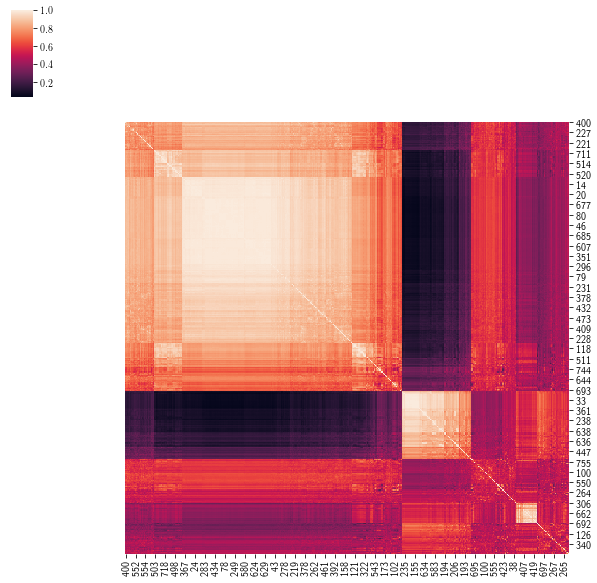

In [312]:
%matplotlib inline
clustermap = sns.clustermap(rep.cos)
clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)

Text(0.5, 1.0, "Cosine := $\\frac{1}{n'} \\sum_{i = 1}^{n'} \\frac{\\langle grad_{\\mathcal M} g_j (\\xi_i) ,grad_{\\mathcal M} g_{ij'} (\\xi_i)\\rangle}{\\|grad_{\\mathcal M} g_i (\\xi_i) \\|_2 \\| grad_{\\mathcal M} g_j(\\xi_i) \\|_2} $")

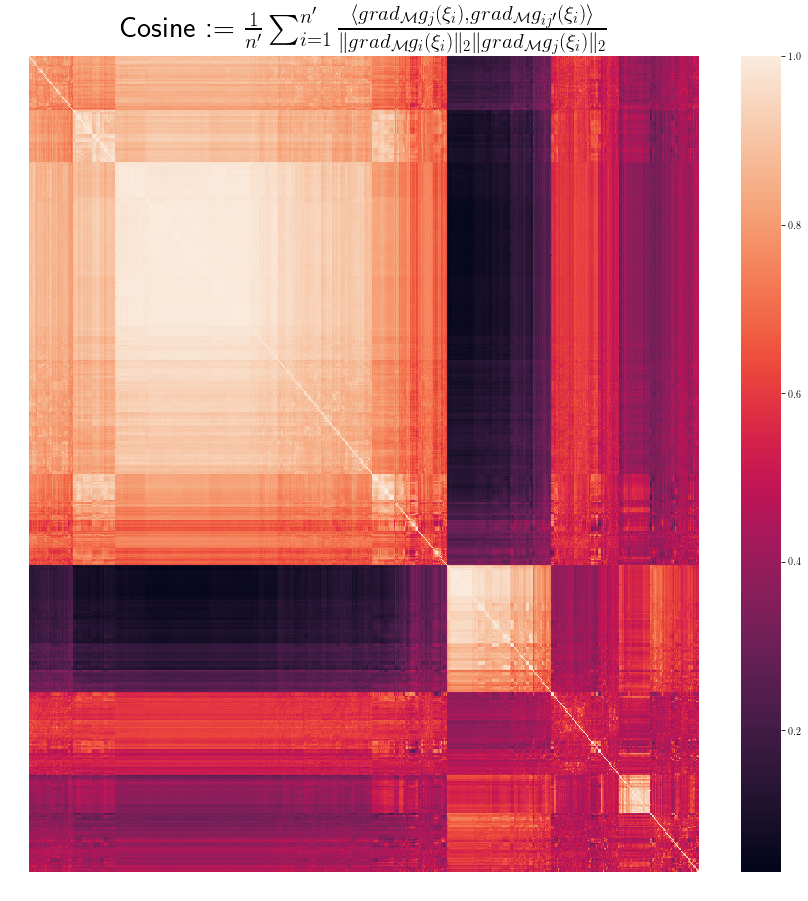

In [328]:
fig, ax = plt.subplots(figsize = (15,15))
ax.set_axis_off()
sns.heatmap(rep.cos[clustermap.dendrogram_col.reordered_ind][:,clustermap.dendrogram_col.reordered_ind], ax = ax)
ax.set_title('Cosine := ' + r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{ij'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_i (\xi_i) \|_2 \| grad_{\mathcal M} g_j(\xi_i) \|_2} $" ,
                fontsize = 30)

In [21]:
for r in range(5):
    #r = 0 
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis

In [292]:
#np.where((cs_reorder**2).sum(axis = 1).sum(axis = 1)[1] !=0.)

In [106]:
nreps = 5
sel_l = np.zeros(nreps, dtype = int)
for r in range(5):
    for l in range(replicates[r].cs_reorder.shape[0]):
        zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(zeros) == 2:
            sel_l[r] = l
            #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))

almost_sel = {}
sel = {}
for r in range(5):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    almost_sel[r] = zeros

In [343]:
def plot_watch3(to_plot, names, colors,ax):
    
    p = to_plot.shape[0]
    #fig, ax = plt.subplots(figsize = (15,15))
    #%matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    #cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    #figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    ax.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'x')
        ax.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = names[j],color=colors[j],
                  fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')

        ax.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 30},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'o', s = 100*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                ax.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    ax.text(x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 20})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')
                #axes.axline((x1, y1), (x2, y2))
    ax.set_aspect(1)
    ax.set_axis_off()

In [268]:
def plot_watch2(to_plot, names, colors):
    
    p = to_plot.shape[0]
    #fig, ax = plt.subplots(figsize = (15,15))
    %matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    axes.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        axes.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'x')
        axes.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = names[j],color=colors[j],
                  fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')

        axes.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 30},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        axes.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'o', s = 100*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                plt.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    axes.text( x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 20})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')
                #axes.axline((x1, y1), (x2, y2))
    axes.set_aspect(1)
    axes.set_axis_off()

In [385]:
#subset

subset_l0 = np.unique(np.asarray(list(sel.values())))
psmallest = len(subset_l0)

to_plot = np.zeros((psmallest, psmallest))

#to_plot = np.zeros(np.repeat(p,d))

#supports = {}
nreps = 5
for r in range(nreps):
    #to_plot[sel]
    
    i_smallest = np.where(subset_l0 == sel[r][0])[0]
    print(sel[r][0], i_smallest)
    
    j_smallest = np.where(subset_l0 == sel[r][1])[0]
    print(sel[r][0], j_smallest)
    
    to_plot[i_smallest,j_smallest] +=1
    to_plot[j_smallest,i_smallest] +=1
    
names_l0 = np.zeros(len(subset_l0), dtype = object)
for s in range(len(subset_l0)):
    names_l0[s] = r"$g_{{{}}}$".format(subset_l0[s])



721 [2]
721 [3]
196 [0]
196 [2]
721 [2]
721 [4]
721 [2]
721 [3]
197 [1]
197 [2]


In [375]:
sel_total = almost_sel

#subset

subset = np.unique(np.concatenate(list(sel_total.values())))
psmallest = len(subset)

to_plot = np.zeros((psmallest, psmallest))

#to_plot = np.zeros(np.repeat(p,d))

#supports = {}
nreps = 5
for r in range(nreps):
    #to_plot[sel]
    
    i_smallest = np.where(subset == sel[r][0])[0]
    print(sel[r][0], i_smallest)
    
    j_smallest = np.where(subset == sel[r][1])[0]
    print(sel[r][0], j_smallest)
    
    to_plot[i_smallest,j_smallest] +=1
    to_plot[j_smallest,i_smallest] +=1
    
names = np.zeros(len(subset), dtype = object)
for s in range(len(subset)):
    names[s] = r"$g_{{{}}}$".format(subset[s])

cmap = plt.get_cmap('brg',len(subset))

colors_subset = np.zeros((len(subset),4))
for s in range(len(subset)):
    #colors_r0[s] = cmap.colors[np.where(subset == r0subset[s])[0]]
    colors_subset[s] = cmap(s)
    print(cmap(s))


721 [11]
721 [12]
196 [1]
196 [11]
721 [11]
721 [13]
721 [11]
721 [12]
197 [2]
197 [11]
(0.0, 0.0, 1.0, 1.0)
(0.15384615384615385, 0.0, 0.8461538461538461, 1.0)
(0.3076923076923077, 0.0, 0.6923076923076923, 1.0)
(0.46153846153846156, 0.0, 0.5384615384615384, 1.0)
(0.6153846153846154, 0.0, 0.3846153846153846, 1.0)
(0.7692307692307693, 0.0, 0.23076923076923073, 1.0)
(0.9230769230769231, 0.0, 0.07692307692307687, 1.0)
(0.9230769230769229, 0.07692307692307707, 0.0, 1.0)
(0.7692307692307692, 0.23076923076923078, 0.0, 1.0)
(0.6153846153846154, 0.38461538461538464, 0.0, 1.0)
(0.46153846153846156, 0.5384615384615384, 0.0, 1.0)
(0.3076923076923074, 0.6923076923076926, 0.0, 1.0)
(0.15384615384615385, 0.8461538461538461, 0.0, 1.0)
(0.0, 1.0, 0.0, 1.0)


In [379]:
names

array(['$g_{33}$', '$g_{196}$', '$g_{197}$', '$g_{213}$', '$g_{214}$',
       '$g_{588}$', '$g_{591}$', '$g_{612}$', '$g_{624}$', '$g_{638}$',
       '$g_{656}$', '$g_{721}$', '$g_{722}$', '$g_{740}$'], dtype=object)

In [377]:
colors_l0 = np.zeros((len(subset_l0),4 ))
for s in range(len(subset_l0)):
    colors_l0[s] = colors_subset[np.where(subset == subset_l0[s])[0]]

1.0 0.0
0.30901699437494745 0.9510565162951535
-0.8090169943749473 0.5877852522924732
-0.8090169943749475 -0.587785252292473
0.30901699437494723 -0.9510565162951536


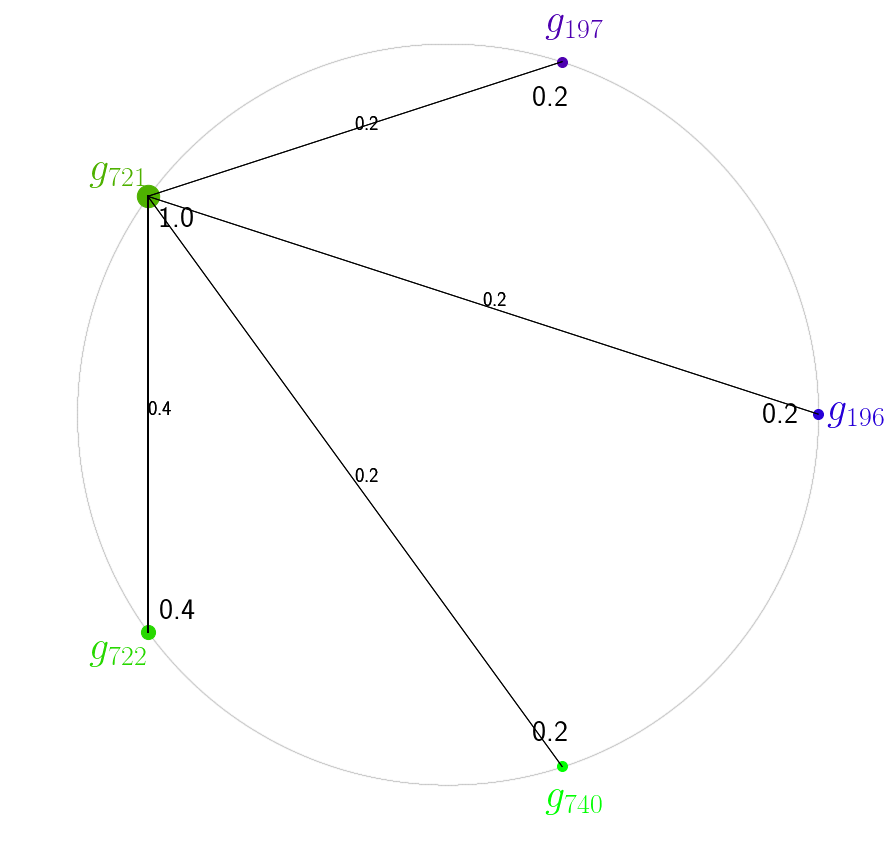

In [381]:
#subset

almost_subset = np.unique(np.concatenate(list(almost_sel.values())))

colors_last = np.zeros((len(subset), 4))
for s in range(len(subset)):
    colors_last[s] = colors_subset[np.where(almost_subset == subset[s] )[0]]

plot_watch2(to_plot, names=names_l0, colors=colors_l0)

Text(0.5, 1.0, 'Cosines of selected gradients')

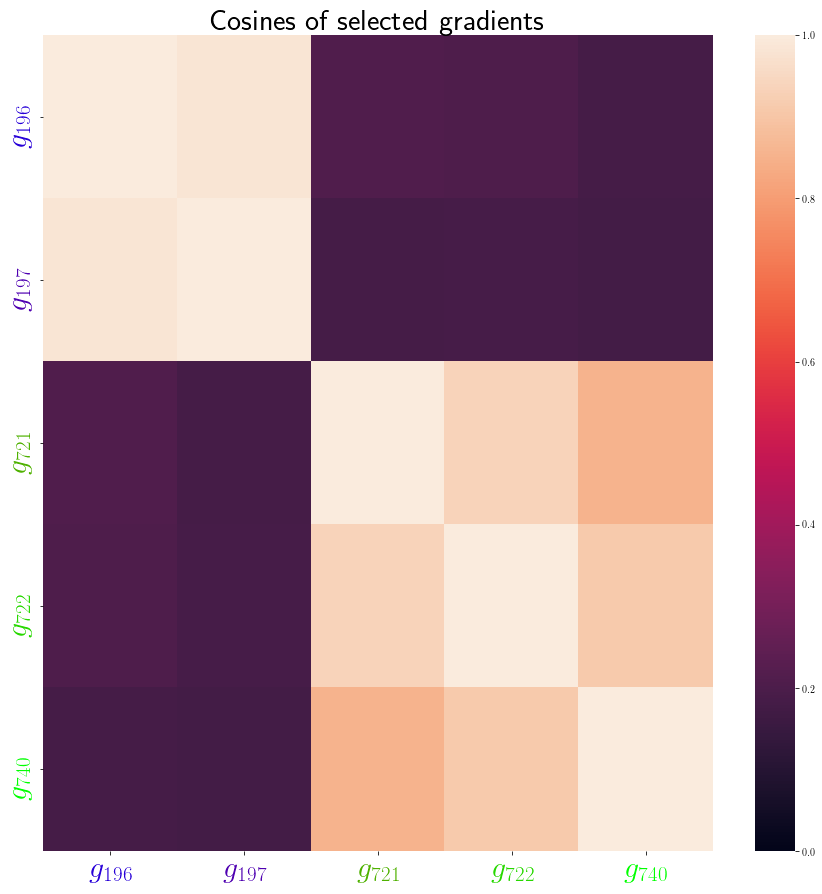

In [371]:
subset_l0 = np.unique(np.asarray(list(sel.values())))
cuz = get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset_l0], 1,2))
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(cuz, yticklabels = names, xticklabels = names, ax = ax, vmin = 0., vmax = 1.)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 30)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 30)


for xtick, color in zip(ax.get_xticklabels(), colors_last):
    xtick.set_color(color)
    
for ytick, color in zip(ax.get_yticklabels(), colors_last):
    ytick.set_color(color)
    
ax.set_title('Cosines of selected gradients')

721 [11]
721 [12]
196 [1]
196 [11]
721 [11]
721 [13]
721 [11]
721 [12]
197 [2]
197 [11]
(0.0, 0.0, 1.0, 1.0)
(0.15384615384615385, 0.0, 0.8461538461538461, 1.0)
(0.3076923076923077, 0.0, 0.6923076923076923, 1.0)
(0.46153846153846156, 0.0, 0.5384615384615384, 1.0)
(0.6153846153846154, 0.0, 0.3846153846153846, 1.0)
(0.7692307692307693, 0.0, 0.23076923076923073, 1.0)
(0.9230769230769231, 0.0, 0.07692307692307687, 1.0)
(0.9230769230769229, 0.07692307692307707, 0.0, 1.0)
(0.7692307692307692, 0.23076923076923078, 0.0, 1.0)
(0.6153846153846154, 0.38461538461538464, 0.0, 1.0)
(0.46153846153846156, 0.5384615384615384, 0.0, 1.0)
(0.3076923076923074, 0.6923076923076926, 0.0, 1.0)
(0.15384615384615385, 0.8461538461538461, 0.0, 1.0)
(0.0, 1.0, 0.0, 1.0)


In [374]:
subset

array([ 33, 196, 197, 213, 214, 588, 591, 612, 624, 638, 656, 721, 722,
       740])

In [188]:
# r = 0 
# r0subset = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]


In [291]:
# colors_r0 = np.zeros((len(r0subset),4))
# for s in range(len(r0subset)):
#     #colors_r0[s] = cmap.colors[np.where(subset == r0subset[s])[0]]
#     colors_r0[s] = cmap(s)
#     print(cmap(s))


Text(0.5, 1.0, 'Regularization path (single replicate)')

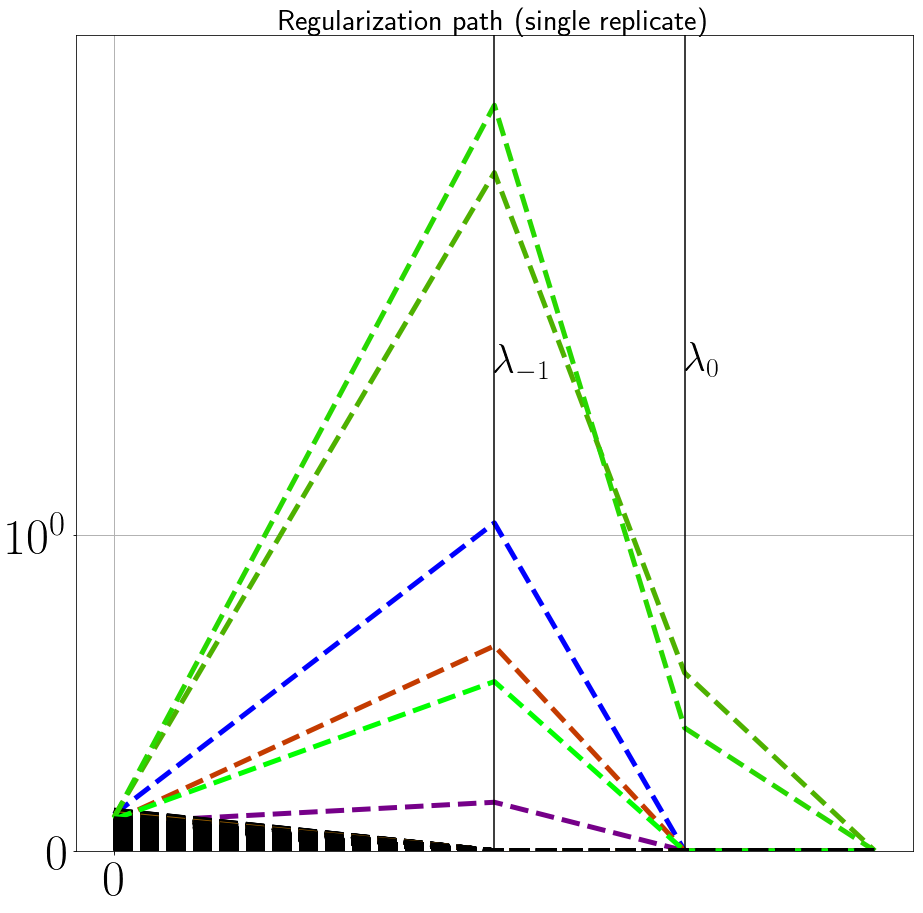

In [363]:

%matplotlib inline
fig, ax = plt.subplots(figsize = (15,15))
colors = np.zeros((756,4))
colors[:,3] = 1

#colors[r0subset] = colors_r0
colors[subset] = colors_subset

r = 0
cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
xaxis_reorder = xaxis[xaxis.argsort()]
cs_reorder = cs[xaxis.argsort()]
xaxis_reorder = xaxis[xaxis.argsort()]
replicates[r].cs = cs
replicates[r].cs_reorder = cs_reorder
replicates[r].xaxis_reorder = xaxis_reorder
replicates[r].xaxis = xaxis

plot_reg_path_ax_lambdasearch_customcolors_norm(ax, cs_reorder, xaxis_reorder * np.sqrt(3 * 5), fig,colors)#axes_all[0].imshow(asdf)

ax.axvline(xaxis_reorder[1] * np.sqrt(3 * 5), color = 'black')
ax.text(xaxis_reorder[1] * np.sqrt(3 * 5), 1.5, r'$\lambda_{-1}$', fontsize = 40)
ax.axvline(xaxis_reorder[2] * np.sqrt(3 * 5), color = 'black')
ax.text(xaxis_reorder[2] * np.sqrt(3 * 5), 1.5, r'$\lambda_{0}$', fontsize = 40)
ax.set_title('Regularization path (single replicate)')

In [366]:
subset

array([ 33, 196, 197, 213, 214, 588, 591, 612, 624, 638, 656, 721, 722,
       740])

In [365]:
colors_sub_l0 = np.zeros((4,5))


Text(0.5, 1.0, 'Cosines of selected gradients at $\\lambda_{-1}$')

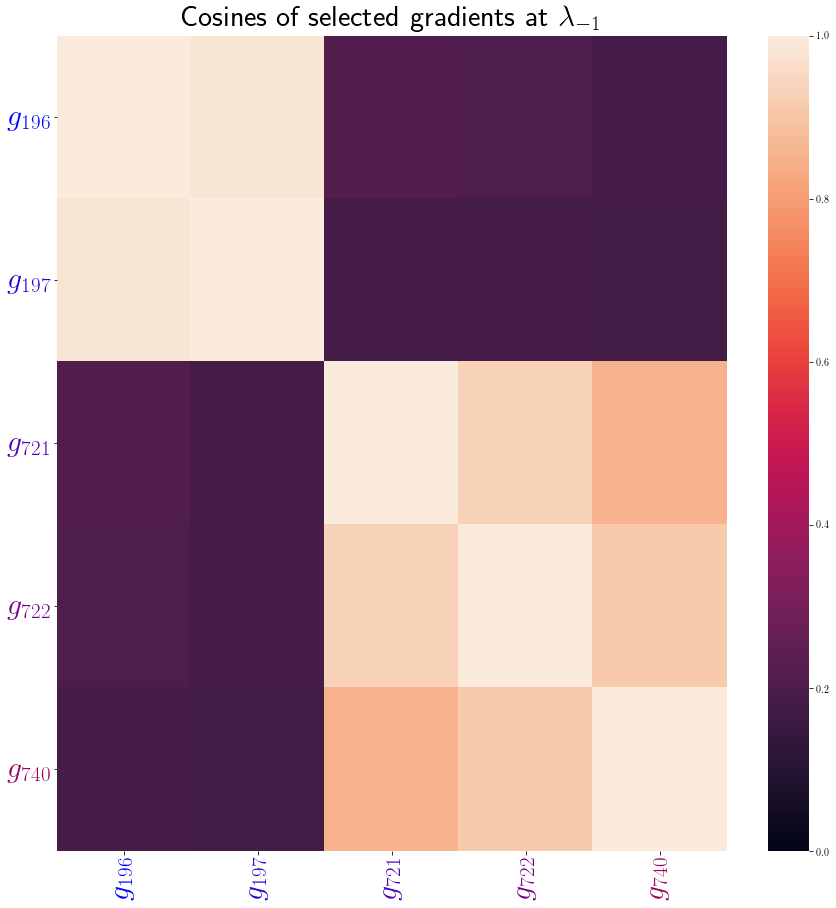

In [323]:
#subset = np.unique(np.asarray(list(sel.values())))
cuz = get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset], 1,2))
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(figsize = (15,15))
#clustermap = sns.clustermap(cuz, yticklabels = names, xticklabels = names, vmin = 0., vmax = 1.,
#                           col_cluster= False, row_cluster= False, col_colors = colors_subset, row_colors = colors_subset)
sns.heatmap(cuz, yticklabels = names, xticklabels = names, vmin = 0., vmax = 1.,ax= ax)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 30, rotation = 90)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 30, rotation = 0)

for xtick, color in zip(ax.get_xticklabels(), colors_subset):
    xtick.set_color(color)
    
for ytick, color in zip(ax.get_yticklabels(), colors_subset):
    ytick.set_color(color)

ax.set_title('Cosines of selected gradients at '+ r"$\lambda_{-1}$")
#clustermap.ax_heatmap.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 30, rotation = 90, colors = colors_subset)
#clustermap.ax_heatmap.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 30, rotation = 0)

In [219]:
sel

{0: array([721, 722]),
 1: array([196, 721]),
 2: array([721, 740]),
 3: array([721, 722]),
 4: array([197, 721])}

In [403]:
#     possebs= np.asarray([362, 624, 661, 721, 722, 740], dtype = int)
#     #def get_olsnorm_and_supportsbrute(experiment, replicates):
#     dim = 2
#     dnoise = 2
#     nreps = 5
#     nsel = 100
#     p = 6

#     parameterizations_possible = np.asarray(list(combinations(range(p), dnoise)))
#     nparameterizations_possible = parameterizations_possible.shape[0]
#     supports_brute = {}
#     penalties = np.zeros((nreps, nparameterizations_possible))
#     ols_norm = np.zeros((nreps, p, p))
#     for r in range(nreps):
#         brute_coeffs = np.zeros((nsel, nparameterizations_possible, 2, 3))
#         orthogonality = np.zeros((nsel, nparameterizations_possible))
#         for i in range(nsel):
#             for j in range(nparameterizations_possible):
#                 brute_coeffs[i, j] = np.linalg.lstsq(np.swapaxes(replicates[r].dg_M[i, :,possebs[parameterizations_possible[j]]],0,1), replicates[r].df_M[i])[0]
#                 # orthogonality[i,j] = get_penalty(brute_coeffs[i,j])
#         for j in range(nparameterizations_possible):
#             penalties[r, j] = experiment.compute_penalty2(np.expand_dims(brute_coeffs[:, j], 0))
#         for j in range(nparameterizations_possible):
#             ols_norm[r, parameterizations_possible[j][0], parameterizations_possible[j][1]] = penalties[r, j]
#             ols_norm[r, parameterizations_possible[j][1], parameterizations_possible[j][0]] = penalties[r, j]
#         supports_brute[r] = parameterizations_possible[penalties[r, :].argmin()]
#     #return (ols_norm, supports_brute)


In [386]:
#subset

subset = np.unique(np.concatenate(list(almost_sel.values())))
psmallest = len(subset)

to_plot_brute = np.zeros((psmallest, psmallest))

#to_plot = np.zeros(np.repeat(p,d))

#supports = {}
nreps = 5
for r in range(nreps):
    #to_plot[sel]
    
    i_smallest = np.where(subset == supports_brute[r][0])[0]
    print(sel[r][0], i_smallest)
    
    j_smallest = np.where(subset == supports_brute[r][1])[0]
    print(sel[r][0], j_smallest)
    
    to_plot_brute[i_smallest,j_smallest] +=1
    to_plot_brute[j_smallest,i_smallest] +=1
    
names = np.zeros(len(subset), dtype = object)
for s in range(len(subset)):
    names[s] = r"$g_{{{}}}$".format(subset[s])



721 [0]
721 [11]
196 [4]
196 [5]
721 [1]
721 [7]
721 [9]
721 [11]
197 [0]
197 [6]


In [246]:
#def get_olsnorm_and_supportsbrute(experiment, replicates):
dim = 2
dnoise = 2
nreps = 5
nsel = 100
#p = 6

supports_brute = {}

for r in range(nreps):
    possebs= almost_sel[r]
    p = len(possebs)
    parameterizations_possible = np.asarray(list(combinations(range(p), dnoise)))
    nparameterizations_possible = parameterizations_possible.shape[0]
    penalties = np.zeros((nreps, nparameterizations_possible))
    #ols_norm = np.zeros((nreps, p, p))
    #subset
    brute_coeffs = np.zeros((nsel, nparameterizations_possible, 2, 3))
    orthogonality = np.zeros((nsel, nparameterizations_possible))
    for i in range(nsel):
        for j in range(nparameterizations_possible):
            brute_coeffs[i, j] = np.linalg.lstsq(np.swapaxes(replicates[r].dg_M[i, :,possebs[parameterizations_possible[j]]],0,1), replicates[r].df_M[i])[0]
            # orthogonality[i,j] = get_penalty(brute_coeffs[i,j])
    for j in range(nparameterizations_possible):
        penalties[r, j] = experiment.compute_penalty2(np.expand_dims(brute_coeffs[:, j], 0))
    print('here')
    sbr = parameterizations_possible[penalties[r, :].argmin()]
    supports_brute[r] = possebs[sbr]
#return (ols_norm, supports_brute)


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


here
here
here
here
here


In [387]:
subset = np.unique(np.concatenate(list(sel_total.values())))
p = subset.shape[0]
to_plot_brute = np.zeros((p,p))
for r in range(5):
    i_sub = np.where(subset == supports_brute[r][0])
    j_sub = np.where(subset == supports_brute[r][1])
    to_plot_brute[i_sub,j_sub] += 1.
    to_plot_brute[j_sub,i_sub] += 1.

1.0 0.0
0.9009688679024191 0.4338837391175581
0.6234898018587336 0.7818314824680297
0.22252093395631445 0.9749279121818236
-0.22252093395631434 0.9749279121818236
-0.6234898018587334 0.7818314824680299
-0.900968867902419 0.43388373911755823
-1.0 1.2246467991473532e-16
-0.9009688679024191 -0.433883739117558
-0.6234898018587337 -0.7818314824680297
-0.2225209339563146 -0.9749279121818235
0.2225209339563142 -0.9749279121818236
0.6234898018587334 -0.7818314824680299
0.900968867902419 -0.4338837391175583


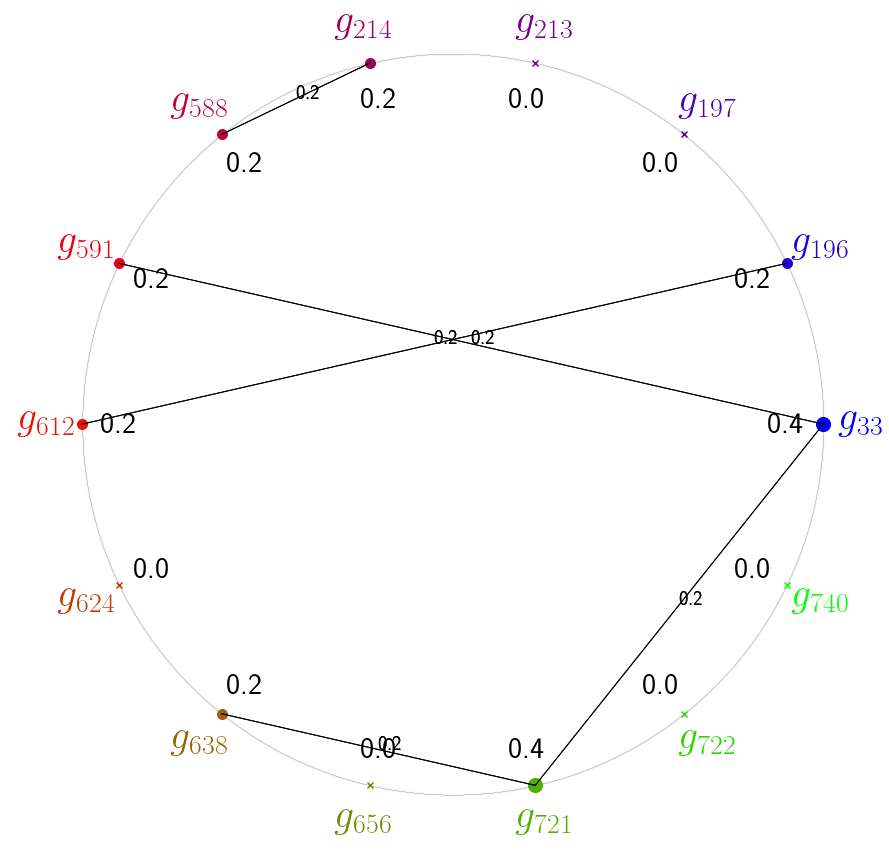

In [271]:
names = np.zeros(len(subset), dtype = object)
for s in range(len(subset)):
    names[s] = r"$g_{{{}}}$".format(subset[s])
plot_watch2(to_plot, names, colors_subset)

In [272]:
supports_brute

{0: array([ 33, 721]),
 1: array([214, 588]),
 2: array([196, 612]),
 3: array([638, 721]),
 4: array([ 33, 591])}

In [273]:
#supports_brute
for r in range(5):
    print(atoms4[supports_brute[r][0]],atoms4[supports_brute[r][1]])

[2 1 8 0] [6 3 7 8]
[0 8 7 2] [2 3 6 7]
[0 8 5 2] [2 4 5 7]
[8 4 2 7] [6 3 7 8]
[2 1 8 0] [6 3 7 2]


In [275]:
g_brute = np.zeros((5,2,50000))
for r in range(5):
    for o in range(2):
        print(o)
        g_brute[r,o] =  experiment.get_g_full_sub(experiment.M.data, atoms4[supports_brute[r][o]])

0
1
0
1
0
1
0
1
0
1


In [264]:
g1fast =  experiment.get_g_full_sub(experiment.M.data, np.asarray([2, 1, 8, 0]))
g2fast = experiment.get_g_full_sub(experiment.M.data, np.asarray([6, 3, 7, 8]))

In [289]:
g_mf = np.zeros((5,2,50000))
for r in range(5):
    for o in range(2):
        print(o)
        g_mf[r,o] =  experiment.get_g_full_sub(experiment.M.data, atoms4[sel[r][o]])

0
1
0
1
0
1
0
1
0
1


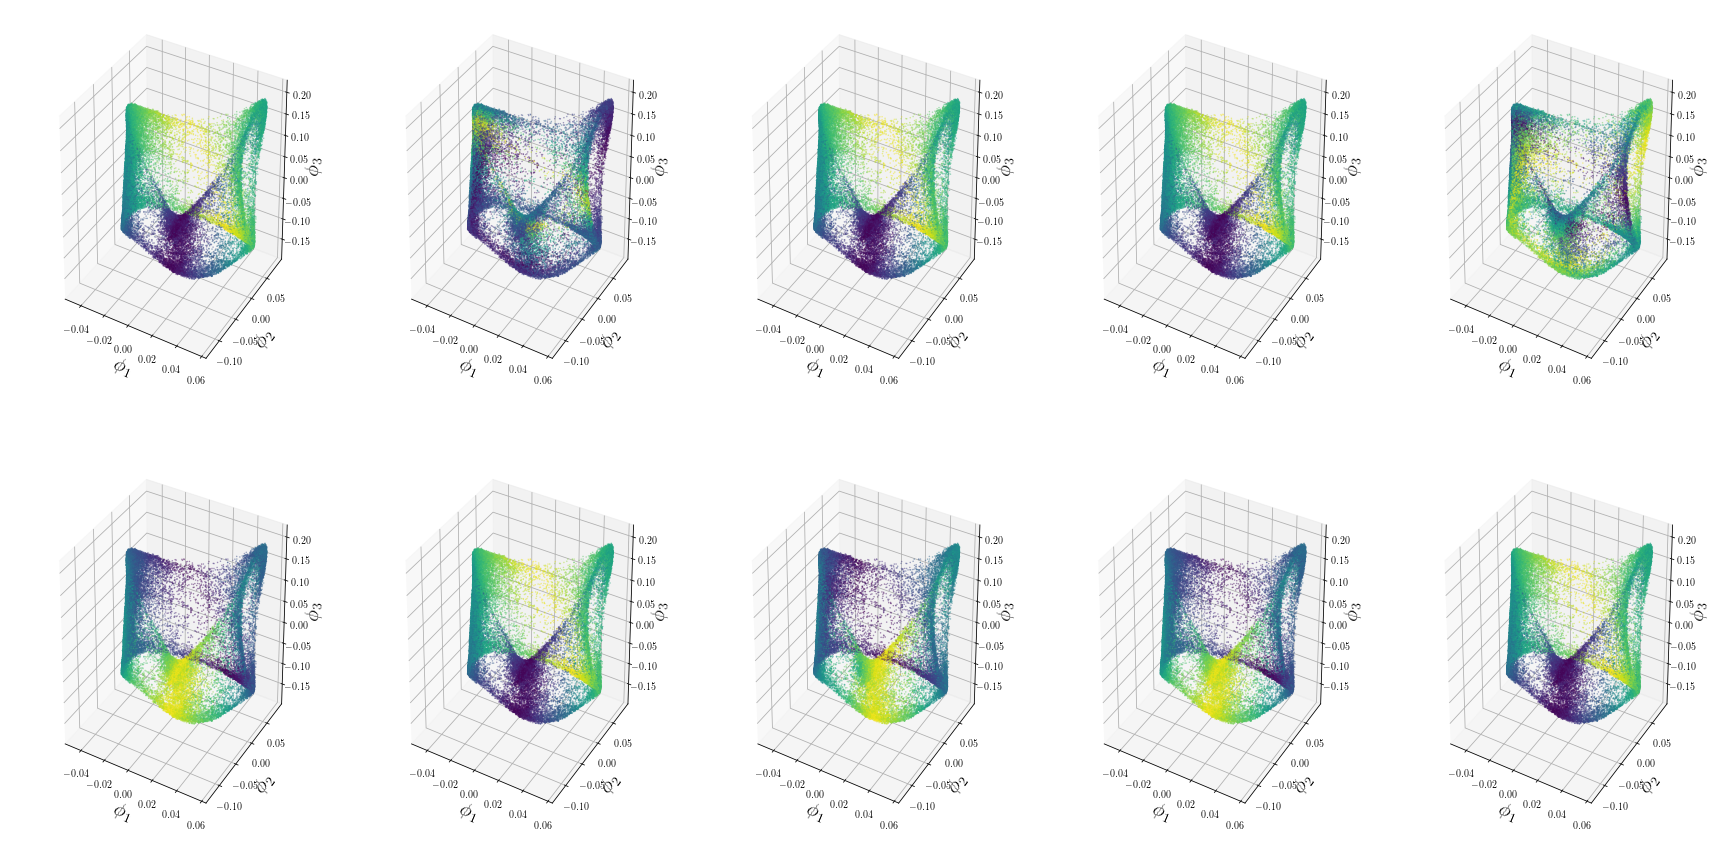

In [290]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(5):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_mf[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 20)
        ax.set_ylabel(r'$\phi_2$', fontsize = 20)
        ax.set_zlabel(r'$\phi_3$', fontsize = 20)
        #ax.set_axis_off()

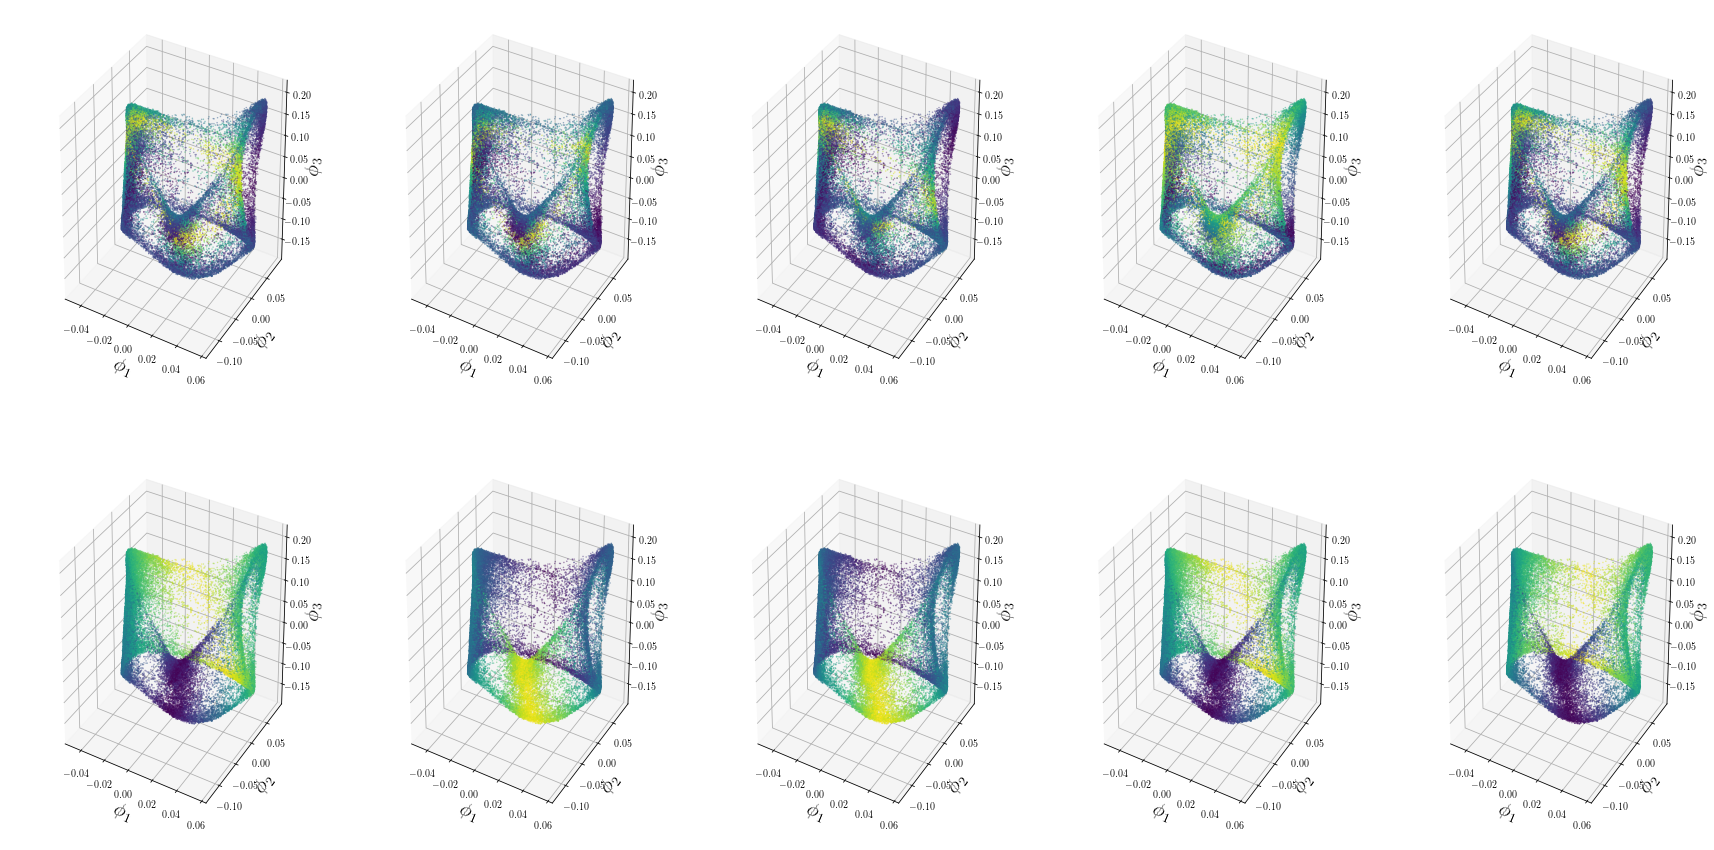

In [287]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,5, figsize = (30,15))

for r in range(5):
    for o in range(2):
        axs[o,r].set_axis_off()
data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
for r in range(5):
    for o in range(2):
        ax = fig.add_subplot(2,5, o*5 + r + 1, projection='3d')
        #fig = plt.figure(figsize=(15,10))
        #ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(x, y, z, c = g_brute[r,o], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
        ax.set_xlabel(r'$\phi_1$', fontsize = 20)
        ax.set_ylabel(r'$\phi_2$', fontsize = 20)
        ax.set_zlabel(r'$\phi_3$', fontsize = 20)
        #ax.set_axis_off()

In [ ]:
f, axarr = plt.subplots(2, 2, figsize=(40, 40))

axarr[0,0].imshow(mpimg.imread('/Users/samsonkoelle/eth_cos_cluster.png'))
axarr[0,1].imshow(mpimg.imread('/Users/samsonkoelle/eth_sr.png'))
axarr[0,2].imshow(mpimg.imread('/Users/samsonkoelle/eth_badcos.png'))
axarr[1,0].imshow(mpimg.imread('/Users/samsonkoelle/eth_1rep.png'))
axarr[1,1].imshow(mpimg.imread('/Users/samsonkoelle/eth_sr_bp.png'))
axarr[1,2].imshow(mpimg.imread('/Users/samsonkoelle/eth_goodcos.png'))

#axarr[1,0].imshow(mpimg.imread('/Users/samsonkoelle/eth_cos_sel_early.png'))
#axarr[1,1].imshow(mpimg.imread('/Users/samsonkoelle/eth_bp_sel_early.png'))

#axarr[0,2].imshow(mpimg.imread('/Users/samsonkoelle/eth_cos_sel.png'))

#axarr[1,0].imshow(mpimg.imread('/Users/samsonkoelle/eth_1rep.png'))
#axarr[1,0].imshow(mpimg.imread('/Users/samsonkoelle/eth_sel_early.png'))

#axarr[1,2].imshow(mpimg.imread('/Users/samsonkoelle/eth_bp_sel_early.png'))


# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]


#axarr[0,0].set_position([-.05, 0.45, 0.55,  0.55])
#axarr[0,1].set_position([0.55, 0.5, 0.35,  0.35])
#axarr[1,0].set_position([0.0, 0., 0.4,  0.4])
#axarr[1,1].set_position([0.45, 0., 0.55,  0.55])
# f.axes[1].set_position([0.05, 0.45, 0.4,  0.05])
# f.axes[2].set_position([0.45, 0.05, 0.05, 0.4])
# f.axes[3].set_position([0.55, 0.05, 0.4,  0.4])
# f.axes[4].set_position([0.55, 0.45, 0.4,  0.05])
# f.axes[5].set_position([0.95, 0.05, 0.05, 0.4])

# plt.tight_layout()
# plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/Figure5')

1.0 0.0
0.30901699437494745 0.9510565162951535
-0.8090169943749473 0.5877852522924732
-0.8090169943749475 -0.587785252292473
0.30901699437494723 -0.9510565162951536
1.0 0.0
0.9009688679024191 0.4338837391175581
0.6234898018587336 0.7818314824680297
0.22252093395631445 0.9749279121818236
-0.22252093395631434 0.9749279121818236
-0.6234898018587334 0.7818314824680299
-0.900968867902419 0.43388373911755823
-1.0 1.2246467991473532e-16
-0.9009688679024191 -0.433883739117558
-0.6234898018587337 -0.7818314824680297
-0.2225209339563146 -0.9749279121818235
0.2225209339563142 -0.9749279121818236
0.6234898018587334 -0.7818314824680299
0.900968867902419 -0.4338837391175583


[Text(0, 0.5, '$g_{33}$'),
 Text(0, 1.5, '$g_{196}$'),
 Text(0, 2.5, '$g_{197}$'),
 Text(0, 3.5, '$g_{213}$'),
 Text(0, 4.5, '$g_{214}$'),
 Text(0, 5.5, '$g_{588}$'),
 Text(0, 6.5, '$g_{591}$'),
 Text(0, 7.5, '$g_{612}$'),
 Text(0, 8.5, '$g_{624}$'),
 Text(0, 9.5, '$g_{638}$'),
 Text(0, 10.5, '$g_{656}$'),
 Text(0, 11.5, '$g_{721}$'),
 Text(0, 12.5, '$g_{722}$'),
 Text(0, 13.5, '$g_{740}$')]

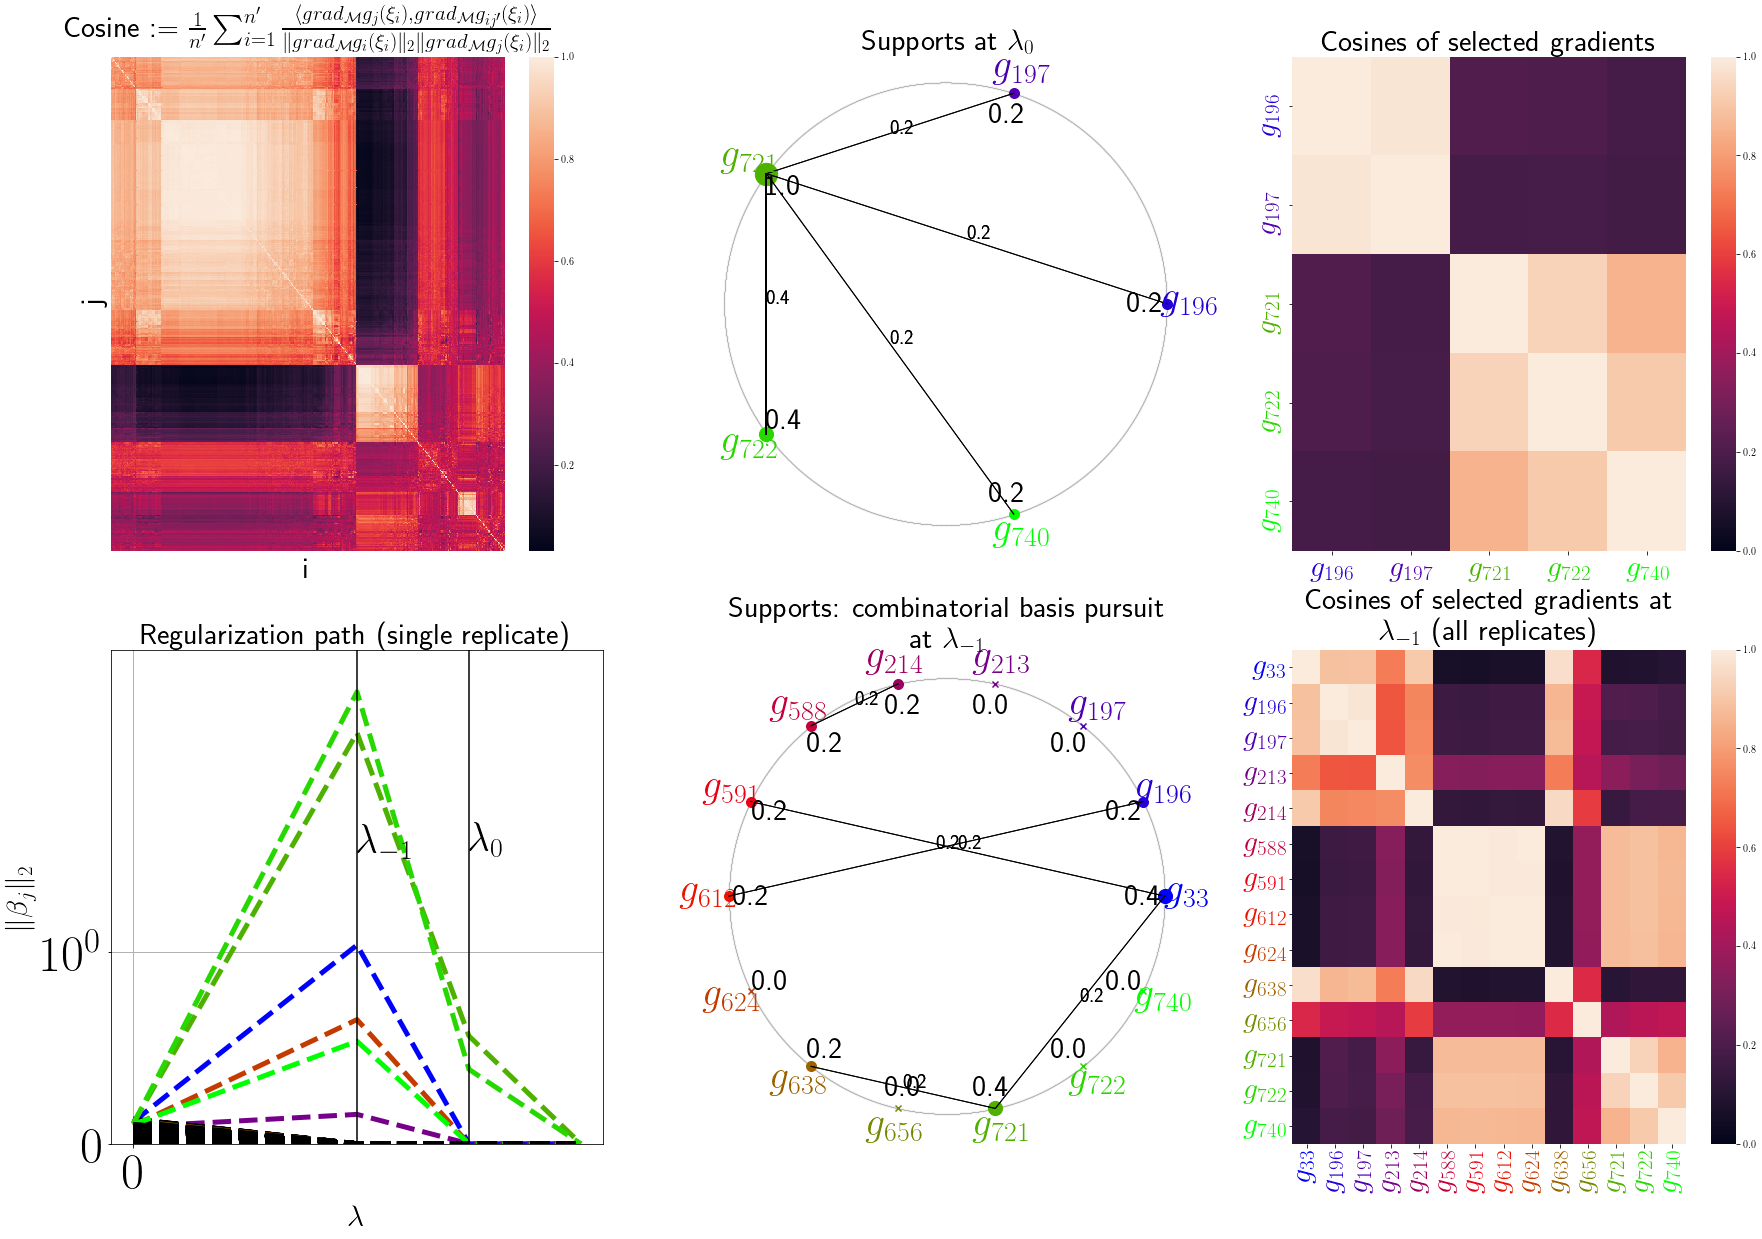

In [401]:
f, axarr = plt.subplots(2,3, figsize=(30, 20))
#[ax.set_axis_off() for ax in axarr.ravel()]

sns.heatmap(rep.cos[clustermap.dendrogram_col.reordered_ind][:,clustermap.dendrogram_col.reordered_ind], ax = axarr[0,0])
axarr[0,0].set_title('Cosine := ' + r"$\frac{1}{n'} \sum_{i = 1}^{n'} \frac{\langle grad_{\mathcal M} g_j (\xi_i) ,grad_{\mathcal M} g_{ij'} (\xi_i)\rangle}{\|grad_{\mathcal M} g_i (\xi_i) \|_2 \| grad_{\mathcal M} g_j(\xi_i) \|_2} $" ,
                fontsize = 30)
axarr[0,0].set_xticklabels([])
axarr[0,0].set_yticklabels([])
axarr[0,0].set_xticks([])
axarr[0,0].set_yticks([])
axarr[0,0].set_xlabel('i', fontsize= 30)
axarr[0,0].set_ylabel('j', fontsize= 30)

plot_watch3(to_plot, names=names_l0, colors=colors_l0, ax = axarr[0,1])
axarr[0,1].set_title('Supports at ' + r'$\lambda_0$', fontsize=  30)

cuz_l0 = get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset_l0], 1,2))
sns.heatmap(cuz_l0, yticklabels = names_l0, xticklabels = names_l0, ax = axarr[0,2], vmin = 0., vmax = 1.)
axarr[0,2].set_xticklabels(axarr[0,2].get_xmajorticklabels(), fontsize = 30)
axarr[0,2].set_yticklabels(axarr[0,2].get_ymajorticklabels(), fontsize = 30)
for xtick, color in zip(axarr[0,2].get_xticklabels(), colors_l0):
    xtick.set_color(color)
for ytick, color in zip(axarr[0,2].get_yticklabels(), colors_l0):
    ytick.set_color(color)
axarr[0,2].set_title('Cosines of selected gradients')


r= 0
colors = np.zeros((756,4))
colors[:,3] = 1

#colors[r0subset] = colors_r0
colors[subset] = colors_subset

cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
xaxis_reorder = xaxis[xaxis.argsort()]
cs_reorder = cs[xaxis.argsort()]
xaxis_reorder = xaxis[xaxis.argsort()]
replicates[r].cs = cs
replicates[r].cs_reorder = cs_reorder
replicates[r].xaxis_reorder = xaxis_reorder
replicates[r].xaxis = xaxis

plot_reg_path_ax_lambdasearch_customcolors_norm(axarr[1,0], cs_reorder, xaxis_reorder * np.sqrt(3 * 5), fig,colors)#axes_all[0].imshow(asdf)
axarr[1,0].set_xlabel(r'$\lambda$', fontsize = 30)
axarr[1,0].set_ylabel(r'$\|\beta_j\|_2$', fontsize = 30)

axarr[1,0].axvline(xaxis_reorder[1] * np.sqrt(3 * 5), color = 'black')
axarr[1,0].text(xaxis_reorder[1] * np.sqrt(3 * 5), 1.5, r'$\lambda_{-1}$', fontsize = 40)
axarr[1,0].axvline(xaxis_reorder[2] * np.sqrt(3 * 5), color = 'black')
axarr[1,0].text(xaxis_reorder[2] * np.sqrt(3 * 5), 1.5, r'$\lambda_{0}$', fontsize = 40)
axarr[1,0].set_title('Regularization path (single replicate)')

plot_watch3(to_plot_brute, names=names, colors=colors_subset, ax = axarr[1,1])
axarr[1,1].set_title('Supports: combinatorial basis pursuit \n at ' + r'$\lambda_{-1}$' , fontsize=  30)

cuz = get_cosines(np.swapaxes(replicates[0].dg_M[:,:,subset], 1,2))
sns.heatmap(cuz, yticklabels = names, xticklabels = names, ax = axarr[1,2], vmin = 0., vmax = 1.)
axarr[1,2].set_xticklabels(axarr[1,2].get_xmajorticklabels(), fontsize = 30)
axarr[1,2].set_yticklabels(axarr[1,2].get_ymajorticklabels(), fontsize = 30)
for xtick, color in zip(axarr[1,2].get_xticklabels(), colors_subset):
    xtick.set_color(color)
for ytick, color in zip(axarr[1,2].get_yticklabels(), colors_subset):
    ytick.set_color(color)
axarr[1,2].set_title('Cosines of selected gradients at \n'  + r"$\lambda_{-1}$" + ' (all replicates)')
axarr[1,2].set_xticklabels(axarr[1,2].get_xmajorticklabels(), fontsize = 30, rotation = 90)
axarr[1,2].set_yticklabels(axarr[1,2].get_ymajorticklabels(), fontsize = 30, rotation = 0)

array([[0.        , 0.        , 1.        , 1.        ],
       [0.15384615, 0.        , 0.84615385, 1.        ],
       [0.30769231, 0.        , 0.69230769, 1.        ],
       [0.46153846, 0.        , 0.53846154, 1.        ],
       [0.61538462, 0.        , 0.38461538, 1.        ],
       [0.76923077, 0.        , 0.23076923, 1.        ],
       [0.92307692, 0.        , 0.07692308, 1.        ],
       [0.92307692, 0.07692308, 0.        , 1.        ],
       [0.76923077, 0.23076923, 0.        , 1.        ],
       [0.61538462, 0.38461538, 0.        , 1.        ],
       [0.46153846, 0.53846154, 0.        , 1.        ],
       [0.30769231, 0.69230769, 0.        , 1.        ],
       [0.15384615, 0.84615385, 0.        , 1.        ],
       [0.        , 1.        , 0.        , 1.        ]])

In [355]:
subset

array([196, 197, 721, 722, 740])

In [339]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise the

1.0 0.0
0.9009688679024191 0.4338837391175581
0.6234898018587336 0.7818314824680297
0.22252093395631445 0.9749279121818236
-0.22252093395631434 0.9749279121818236
-0.6234898018587334 0.7818314824680299


IndexError: index 5 is out of bounds for axis 0 with size 5

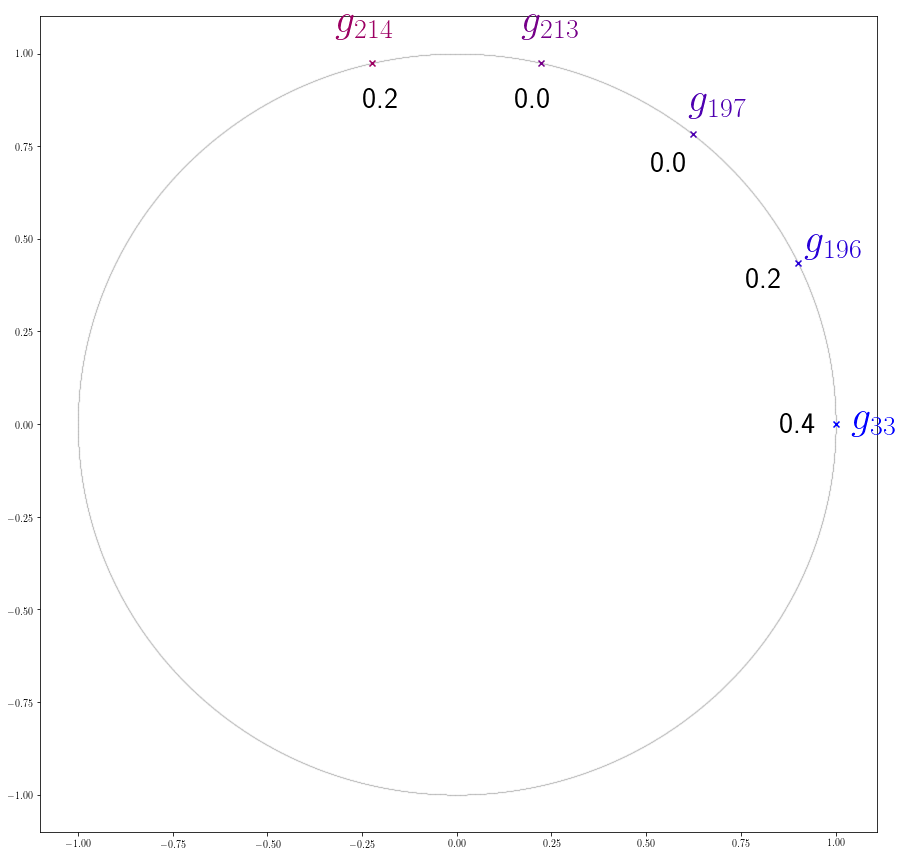

In [360]:
names = np.zeros(len(subset), dtype = object)
for s in range(len(subset)):
    names[s] = r"$g_{{{}}}$".format(subset[s])
plot_watch2(to_plot, names, colors_subset)